In [ ]:
"""
# FELIN Launch Vehicle Optimization with Environmental Objectives
# Using CMA-ES with Augmented Lagrangian and SLSQP
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openmdao.api as om
import cma
from scipy.optimize import minimize
import time
import sys
import io
import warnings
warnings.filterwarnings('ignore')

# Import FELIN modules
from Launch_vehicle_Group import LauncherVehicleGroup
import result_vizualization

import logging
logging.getLogger('openmdao').setLevel(logging.ERROR)

# Set print options
np.set_printoptions(threshold=100, precision=3)
print("FELIN Environmental Optimization Framework Loaded")

✓ Brightway2 and ecoinvent successfully loaded
✓ Environmental discipline loaded
FELIN Environmental Optimization Framework Loaded


In [2]:
"""
## Problem Definition
Minimize ESA environmental score subject to:
- ΔV ≥ 7800 m/s (reach orbital velocity)
- Altitude ≥ 300 km (reach target altitude)
- GLOW ≤ 500 t (launcher size constraint)
"""

# Design variable bounds
lowerbnd = np.array([
    230., 40.,           # Propellant masses (t)
    4.5, 4.5,           # O/F ratios
    0.00, 0.00, 0.00,   # Stage 1 structural materials (CFRP, Al, Steel)
    0.00, 0.00, 0.00,   # Stage 2 structural materials
    0., 5., 0.2,        # Trajectory: thetacmd_i, thetacmd_f, ksi
    5., 5., 1.,         # Pitch_over_duration, Delta_vertical, Delta_theta
    -30., -30.          # command_stage_1_exo
])

upperbnd = np.array([
    380., 80.,          # Propellant masses (t)
    6.0, 6.0,           # O/F ratios
    1.00, 1.00, 1.00,   # Stage 1 structural materials (fractions)
    1.00, 1.00, 1.00,   # Stage 2 structural materials
    5., 15., 0.4,       # Trajectory params
    10., 15., 5.,       # More trajectory
    70., 70.            # Command
])

# Performance requirements
MIN_DELTA_V = 7800.0  # m/s
MIN_ALTITUDE = 300000.0  # m
MAX_GLOW = 500000.0  # kg

print(f"Design variables: {len(lowerbnd)}")
print(f"ΔV requirement: {MIN_DELTA_V} m/s")
print(f"Altitude requirement: {MIN_ALTITUDE/1000} km")
print(f"Soft constraint: GLOW≤{MAX_GLOW/1000} t")

Design variables: 18
ΔV requirement: 7800.0 m/s
Altitude requirement: 300.0 km
Soft constraint: GLOW≤500.0 t


In [3]:
"""
## Baseline Design
Starting from FELIN's original configuration
"""

x_baseline = np.array([
    250., 50.6,         # Propellant masses (t)
    5.5, 5.5,           # O/F ratios
    0.30, 0.60, 0.10,   # Stage 1: 30% CFRP, 60% Al, 10% Steel
    0.40, 0.50, 0.10,   # Stage 2: 40% CFRP, 50% Al, 10% Steel
    2.72, 10., 0.293,   # Trajectory
    5., 10., 1.,        # More trajectory
    30., -20.           # Command
])

# Normalize
x_baseline_norm = (x_baseline - lowerbnd) / (upperbnd - lowerbnd)
print(f"Baseline normalized: {x_baseline_norm[:4]}")  # Show first 4 values

Baseline normalized: [0.133 0.265 0.667 0.667]


In [4]:
"""
## Fixed Point Iteration for Trajectory-Structure Coupling
Ensures dynamic pressure consistency between disciplines
"""

def run_fpi(x_norm, lowerbnd, upperbnd, prob):
    """
    Fixed Point Iteration with suppressed output
    Resolves Pdyn coupling between trajectory and structure
    """
    
    # Denormalize design variables
    x = lowerbnd + (upperbnd - lowerbnd) * x_norm
    
    # Set all design variables
    prob['Prop_mass_stage_1'] = x[0] * 1e3  # kg
    prob['Prop_mass_stage_2'] = x[1] * 1e3
    prob['OF_stage_1'] = x[2]
    prob['OF_stage_2'] = x[3]
    
    # Materials (raw fractions, will be normalized internally)
    prob['raw_cfrp_s1'] = x[4]
    prob['raw_aluminum_s1'] = x[5]
    prob['raw_steel_s1'] = x[6]
    prob['raw_cfrp_s2'] = x[7]
    prob['raw_aluminum_s2'] = x[8]
    prob['raw_steel_s2'] = x[9]
    
    # Trajectory parameters
    prob['thetacmd_i'] = x[10]
    prob['thetacmd_f'] = x[11]
    prob['ksi'] = x[12]
    prob['Pitch_over_duration'] = x[13]
    prob['Delta_vertical_phase'] = x[14]
    prob['Delta_theta_pitch_over'] = x[15]
    prob['command_stage_1_exo'] = x[16:18]
    
    # Fixed operational parameters
    prob['Diameter_stage_1'] = 5.0
    prob['Diameter_stage_2'] = 5.0
    prob['Mass_flow_rate_stage_1'] = 250.
    prob['Mass_flow_rate_stage_2'] = 250.
    prob['Thrust_stage_1'] = 1000.
    prob['Thrust_stage_2'] = 800.
    prob['Pc_stage_1'] = 100.0
    prob['Pc_stage_2'] = 100.0
    prob['Pe_stage_1'] = 1.0
    prob['Pe_stage_2'] = 1.0
    prob['N_eng_stage_1'] = 8.
    prob['N_eng_stage_2'] = 1.
    prob['Exit_nozzle_area_stage_1'] = 0.79
    prob['Exit_nozzle_area_stage_2'] = 3.6305
    prob['is_fallout'] = 0.
    prob['payload_mass'] = 5000.0
    
    # FPI loop for Pdyn convergence (trajectory-structure coupling)
    error = 100.
    prob['Pdyn_max_dim'] = 36.24  # Initial guess
    k = 0
    max_iter = 15
    
    while error > 1. and k < max_iter:
        try:
            # Suppress output
            old_stdout = sys.stdout
            sys.stdout = io.StringIO()
            
            prob.run_model()
            
            sys.stdout = old_stdout
            
            # Update Pdyn for next iteration
            new_pdyn = prob['max_pdyn_load_ascent_stage_1']/1e3
            error = abs(prob['Pdyn_max_dim'] - new_pdyn)
            prob['Pdyn_max_dim'] = new_pdyn
            k += 1
            
        except Exception as e:
            sys.stdout = old_stdout
            return False, {'error': str(e)}
    
    if error > 1.:
        return False, {'error': 'FPI did not converge'}
    
    # Extract results after convergence
    nb_pts = int(prob['Nb_pt_ascent'][0])
    
    results = {
        'ESA_score': prob['ESA_single_score'][0],
        'delta_v': prob['V_ascent'][nb_pts-1] - prob['V_ascent'][0],
        'altitude': prob['alt_ascent'][nb_pts-1],
        'GLOW': prob['GLOW'][0],
        'GWP': prob['GWP_total'][0],
        'converged': True,
        'fpi_iterations': k
    }
    
    return True, results

In [5]:
"""
## Baseline Evaluation
"""

# Setup problem
prob = om.Problem()
prob.model = LauncherVehicleGroup()
prob.setup(check=False)
prob.model.nonlinear_solver.options['iprint'] = -1
prob.model.cycle.nonlinear_solver.options['iprint'] = -1

# Evaluate baseline
converged, baseline_results = run_fpi(x_baseline_norm, lowerbnd, upperbnd, prob)

if converged:
    print(f"✓ Baseline converged in {baseline_results['fpi_iterations']} FPI iterations")
    print(f"Baseline ESA Score: {baseline_results['ESA_score']:.1f}")
    print(f"Baseline ΔV: {baseline_results['delta_v']:.0f} m/s")
    print(f"Baseline Altitude: {baseline_results['altitude']/1000:.0f} km")
    print(f"Baseline GLOW: {baseline_results['GLOW']/1000:.1f} t")
    print(f"  Feasible: {baseline_results['delta_v'] >= MIN_DELTA_V and baseline_results['altitude'] >= MIN_ALTITUDE}")

    # Show baseline material distribution
    print("\nBaseline structural materials:")
    print(f"  Stage 1: CFRP={x_baseline[4]:.0%}, Al={x_baseline[5]:.0%}, Steel={x_baseline[6]:.0%}")
    print(f"  Stage 2: CFRP={x_baseline[7]:.0%}, Al={x_baseline[8]:.0%}, Steel={x_baseline[9]:.0%}")


✓ Baseline converged in 2 FPI iterations
Baseline ESA Score: 82.8
Baseline ΔV: 7562 m/s
Baseline Altitude: 317 km
Baseline GLOW: 343.8 t
  Feasible: False

Baseline structural materials:
  Stage 1: CFRP=30%, Al=60%, Steel=10%
  Stage 2: CFRP=40%, Al=50%, Steel=10%


In [6]:
"""
## Method 1: CMA-ES with Death Penalty
No dimension mixing - infeasible solutions get very high score
"""
global eval_count
eval_count = 0

def objective_cmaes(x):
    """
    Phase 1: Minimize constraint violation (dimensionless)
    Phase 2: Minimize ESA score (once feasible)
    """
    converged, results = run_fpi(x, lowerbnd, upperbnd, prob)
    
    if not converged:
        return 1e10
    
    # Compute constraint violations (normalized to be dimensionless)
    viol_dv = max(0, (MIN_DELTA_V - results['delta_v']) / MIN_DELTA_V)  # Fraction violated
    viol_alt = max(0, (MIN_ALTITUDE - results['altitude']) / MIN_ALTITUDE)  # Fraction violated
    
    total_violation = viol_dv + viol_alt
    
    if total_violation > 0:
        # Phase 1: Return violation measure (0 to 2, dimensionless)
        # Scale to large values so CMA-ES prioritizes feasibility
        return 1000 * total_violation
    else:
        # Phase 2: Return ESA score for feasible solutions
        return results['ESA_score']

print("\nStarting CMA-ES optimization with death penalty...")
print("(Only feasible solutions will be accepted)")

t0 = time.time()
eval_count = 0

# Suppress CMA-ES output
old_stdout = sys.stdout
sys.stdout = io.StringIO()

try:
    res_cmaes = cma.fmin(
        objective_cmaes,
        x_baseline_norm,
        0.15,  # sigma - exploration radius
        {
            'bounds': [np.zeros(len(lowerbnd)), np.ones(len(upperbnd))],
            'popsize': 20,
            'maxiter': 30,
            'verb_disp': 0,
            'verb_log': 0,
            'seed': 42
        }
    )
finally:
    sys.stdout = old_stdout

x_opt_cmaes = res_cmaes[0]
converged, results_cmaes = run_fpi(x_opt_cmaes, lowerbnd, upperbnd, prob)

print(f"\n✓ CMA-ES complete in {time.time()-t0:.1f}s ({eval_count} evaluations)")
if converged:
    x_cmaes_denorm = lowerbnd + (upperbnd - lowerbnd) * x_opt_cmaes
    print(f"  ESA Score: {results_cmaes['ESA_score']:.1f}")
    print(f"  ΔV: {results_cmaes['delta_v']:.0f} m/s {'✓' if results_cmaes['delta_v'] >= MIN_DELTA_V else '✗'}")
    print(f"  Alt: {results_cmaes['altitude']/1000:.0f} km {'✓' if results_cmaes['altitude'] >= MIN_ALTITUDE else '✗'}")
    print(f"  GLOW: {results_cmaes['GLOW']/1000:.1f} t")
    print(f"  Stage 1 materials: CFRP={x_cmaes_denorm[4]:.0%}, Al={x_cmaes_denorm[5]:.0%}, Steel={x_cmaes_denorm[6]:.0%}")
    print(f"  Stage 2 materials: CFRP={x_cmaes_denorm[7]:.0%}, Al={x_cmaes_denorm[8]:.0%}, Steel={x_cmaes_denorm[9]:.0%}")


Starting CMA-ES optimization with death penalty...
(Only feasible solutions will be accepted)

✓ CMA-ES complete in 3871.2s (0 evaluations)
  ESA Score: 106.2
  ΔV: 7799 m/s ✗
  Alt: 320 km ✓
  GLOW: 387.3 t
  Stage 1 materials: CFRP=90%, Al=28%, Steel=2%
  Stage 2 materials: CFRP=68%, Al=37%, Steel=15%


In [7]:
"""
## Method 2: SLSQP with Direct Constraint Handling
Gradient-based method with explicit constraints
"""

eval_count_slsqp = 0

def objective_slsqp(x):
    """SLSQP objective - just returns ESA score"""
    global eval_count_slsqp
    eval_count_slsqp += 1
    
    converged, results = run_fpi(x, lowerbnd, upperbnd, prob)
    
    if eval_count_slsqp % 20 == 0:
        print(f"  Eval {eval_count_slsqp}: ESA={results['ESA_score'] if converged else 'fail':.1f}")
    
    return results['ESA_score'] if converged else 1e10

# Constraint functions (must return ≥ 0 for feasibility)
def constraint_deltav(x):
    _, results = run_fpi(x, lowerbnd, upperbnd, prob)
    return results['delta_v'] - MIN_DELTA_V if results else -1e10

def constraint_altitude(x):
    _, results = run_fpi(x, lowerbnd, upperbnd, prob)
    return results['altitude'] - MIN_ALTITUDE if results else -1e10

def constraint_glow(x):
    _, results = run_fpi(x, lowerbnd, upperbnd, prob)
    return MAX_GLOW - results['GLOW'] if results else -1e10

# Material sum constraints (must sum to 1.0 for proper normalization)
def constraint_mat_sum_s1(x):
    return 1.0 - (x[4] + x[5] + x[6])  # Should be close to 0

def constraint_mat_sum_s2(x):
    return 1.0 - (x[7] + x[8] + x[9])  # Should be close to 0

# Define constraints for SLSQP
constraints = [
    {'type': 'ineq', 'fun': constraint_deltav},   # Hard
    {'type': 'ineq', 'fun': constraint_altitude}, # Hard
    {'type': 'ineq', 'fun': constraint_glow}      # Soft
]

print("\nStarting SLSQP optimization...")
print("(Using direct constraint handling)")

t0 = time.time()
eval_count_slsqp = 0

res_slsqp = minimize(
    objective_slsqp,
    x_baseline_norm,
    method='SLSQP',
    bounds=[(0, 1)] * len(lowerbnd),
    constraints=constraints,
    options={'ftol': 1e-8, 'maxiter': 100, 'disp': False}
)

x_opt_slsqp = res_slsqp.x
converged, results_slsqp = run_fpi(x_opt_slsqp, lowerbnd, upperbnd, prob)

print(f"\n✓ SLSQP complete in {time.time()-t0:.1f}s ({eval_count_slsqp} evaluations)")
print(f"  Success: {res_slsqp.success}, Message: {res_slsqp.message}")
if converged:
    x_slsqp_denorm = lowerbnd + (upperbnd - lowerbnd) * x_opt_slsqp
    print(f"  ESA Score: {results_slsqp['ESA_score']:.1f}")
    print(f"  ΔV: {results_slsqp['delta_v']:.0f} m/s {'✓' if results_slsqp['delta_v'] >= MIN_DELTA_V else '✗'}")
    print(f"  Alt: {results_slsqp['altitude']/1000:.0f} km {'✓' if results_slsqp['altitude'] >= MIN_ALTITUDE else '✗'}")
    print(f"  GLOW: {results_slsqp['GLOW']/1000:.1f} t")
    print(f"  Stage 1 materials: CFRP={x_slsqp_denorm[4]:.0%}, Al={x_slsqp_denorm[5]:.0%}, Steel={x_slsqp_denorm[6]:.0%}")
    print(f"  Stage 2 materials: CFRP={x_slsqp_denorm[7]:.0%}, Al={x_slsqp_denorm[8]:.0%}, Steel={x_slsqp_denorm[9]:.0%}")


Starting SLSQP optimization...
(Using direct constraint handling)
  Eval 20: ESA=65.9
  Eval 40: ESA=65.9
  Eval 60: ESA=65.9
  Eval 80: ESA=65.9
  Eval 100: ESA=65.9
  Eval 120: ESA=65.9
  Eval 140: ESA=65.9
  Eval 160: ESA=65.9
  Eval 180: ESA=66.0
  Eval 200: ESA=66.0
  Eval 220: ESA=66.0
  Eval 240: ESA=65.9
  Eval 260: ESA=65.9
  Eval 280: ESA=65.9
  Eval 300: ESA=65.9
  Eval 320: ESA=67.4
  Eval 340: ESA=67.4
  Eval 360: ESA=67.2
  Eval 380: ESA=67.2
  Eval 400: ESA=67.2
  Eval 420: ESA=67.2
  Eval 440: ESA=67.1
  Eval 460: ESA=67.1
  Eval 480: ESA=67.1
  Eval 500: ESA=67.1
  Eval 520: ESA=67.1
  Eval 540: ESA=67.1
  Eval 560: ESA=67.7
  Eval 580: ESA=67.7
  Eval 600: ESA=68.2
  Eval 620: ESA=67.7
  Eval 640: ESA=67.5
  Eval 660: ESA=67.8
  Eval 680: ESA=67.8
  Eval 700: ESA=65.9
  Eval 720: ESA=65.9
  Eval 740: ESA=65.9
  Eval 760: ESA=65.9
  Eval 780: ESA=65.9
  Eval 800: ESA=65.9
  Eval 820: ESA=65.9
  Eval 840: ESA=65.9
  Eval 860: ESA=65.9
  Eval 880: ESA=65.9
  Eval 900: E

In [8]:
"""
## Results Comparison
"""

# Build comparison table
comparison = pd.DataFrame({
    'Method': ['Baseline', 'CMA-ES', 'SLSQP'],
    'ESA Score': [
        baseline_results['ESA_score'],
        results_cmaes['ESA_score'] if converged else np.nan,
        results_slsqp['ESA_score'] if converged else np.nan
    ],
    'ΔV (m/s)': [
        baseline_results['delta_v'],
        results_cmaes['delta_v'] if converged else np.nan,
        results_slsqp['delta_v'] if converged else np.nan
    ],
    'Alt (km)': [
        baseline_results['altitude']/1000,
        results_cmaes['altitude']/1000 if converged else np.nan,
        results_slsqp['altitude']/1000 if converged else np.nan
    ],
    'GLOW (t)': [
        baseline_results['GLOW']/1000,
        results_cmaes['GLOW']/1000 if converged else np.nan,
        results_slsqp['GLOW']/1000 if converged else np.nan
    ],
    'GWP (tCO2)': [
        baseline_results['GWP']/1000,
        results_cmaes['GWP']/1000 if converged else np.nan,
        results_slsqp['GWP']/1000 if converged else np.nan
    ],
    'Feasible': [
        baseline_results['delta_v'] >= MIN_DELTA_V and baseline_results['altitude'] >= MIN_ALTITUDE,
        results_cmaes['delta_v'] >= MIN_DELTA_V and results_cmaes['altitude'] >= MIN_ALTITUDE if converged else False,
        results_slsqp['delta_v'] >= MIN_DELTA_V and results_slsqp['altitude'] >= MIN_ALTITUDE if converged else False
    ]
})

print("\n" + "="*60)
print("OPTIMIZATION RESULTS COMPARISON")
print("="*60)
print(comparison.round(1).to_string(index=False))

# Find best feasible
feasible_solutions = comparison[comparison['Feasible']]
if not feasible_solutions.empty:
    best_idx = feasible_solutions['ESA Score'].idxmin()
    print(f"\n✓ Best feasible: {feasible_solutions.loc[best_idx, 'Method']}")
    print(f"  ESA Score: {feasible_solutions.loc[best_idx, 'ESA Score']:.1f}")
else:
    print("\n✗ No feasible solution found!")


OPTIMIZATION RESULTS COMPARISON
  Method  ESA Score  ΔV (m/s)  Alt (km)  GLOW (t)  GWP (tCO2)  Feasible
Baseline       82.8    7562.2     316.8     343.8      2177.1     False
  CMA-ES      106.2    7799.0     320.0     387.3      2778.9     False
   SLSQP       66.5    7401.4    1081.0     319.4      1760.3     False

✗ No feasible solution found!


In [9]:
"""
## Optimal Design Analysis
"""

# Select best solution
if results_cmaes['delta_v'] >= MIN_DELTA_V and results_cmaes['altitude'] >= MIN_ALTITUDE:
    x_best = x_opt_cmaes
    best_name = "CMA-ES"
    best_results = results_cmaes
elif results_slsqp['delta_v'] >= MIN_DELTA_V and results_slsqp['altitude'] >= MIN_ALTITUDE:
    x_best = x_opt_slsqp
    best_name = "SLSQP"
    best_results = results_slsqp
else:
    x_best = x_baseline_norm
    best_name = "Baseline (no feasible found)"
    best_results = baseline_results

print(f"Using {best_name} solution")

converged, _ = run_fpi(x_best, lowerbnd, upperbnd, prob)

if converged:
    print("\n=== MASS BREAKDOWN ===")
    print(f"Total dry mass S1: {prob['Dry_mass_stage_1'][0]/1000:.1f} t")
    print(f"Total dry mass S2: {prob['Dry_mass_stage_2'][0]/1000:.1f} t")
    
    print("\n=== MATERIAL MASSES (t) ===")
    print("Stage 1:")
    print(f"  Structural CFRP: {prob['stage1_structure_cfrp'][0]/1000:.1f}")
    print(f"  Structural Al-7075: {prob['stage1_structure_aluminum'][0]/1000:.1f}")
    print(f"  Structural Steel: {prob['stage1_structure_steel'][0]/1000:.1f}")
    print(f"  Tanks (Al): {prob['stage1_tank_aluminum'][0]/1000:.1f}")
    print(f"  Insulation: {prob['stage1_insulation'][0]/1000:.1f}")
    
    print("Stage 2:")
    print(f"  Structural CFRP: {prob['stage2_structure_cfrp'][0]/1000:.1f}")
    print(f"  Structural Al-7075: {prob['stage2_structure_aluminum'][0]/1000:.1f}")
    print(f"  Structural Steel: {prob['stage2_structure_steel'][0]/1000:.1f}")
    print(f"  Tanks (Al): {prob['stage2_tank_aluminum'][0]/1000:.1f}")
    print(f"  Insulation: {prob['stage2_insulation'][0]/1000:.1f}")
    
    print("\nOther:")
    print(f"  Engines: {prob['engines_mass'][0]/1000:.1f}")
    print(f"  Avionics: {prob['avionics_mass'][0]/1000:.1f}")
    print(f"  LOX: {prob['total_lox_mass'][0]/1000:.1f}")
    print(f"  LH2: {prob['total_lh2_mass'][0]/1000:.1f}")

Using Baseline (no feasible found) solution

=== MASS BREAKDOWN ===
Total dry mass S1: 30.5 t
Total dry mass S2: 5.7 t

=== MATERIAL MASSES (t) ===
Stage 1:
  Structural CFRP: 3.2
  Structural Al-7075: 6.4
  Structural Steel: 1.1
  Tanks (Al): 9.1
  Insulation: 1.5
Stage 2:
  Structural CFRP: 0.7
  Structural Al-7075: 0.9
  Structural Steel: 0.2
  Tanks (Al): 2.0
  Insulation: 0.3

Other:
  Engines: 7.0
  Avionics: 2.1
  LOX: 254.4
  LH2: 46.2


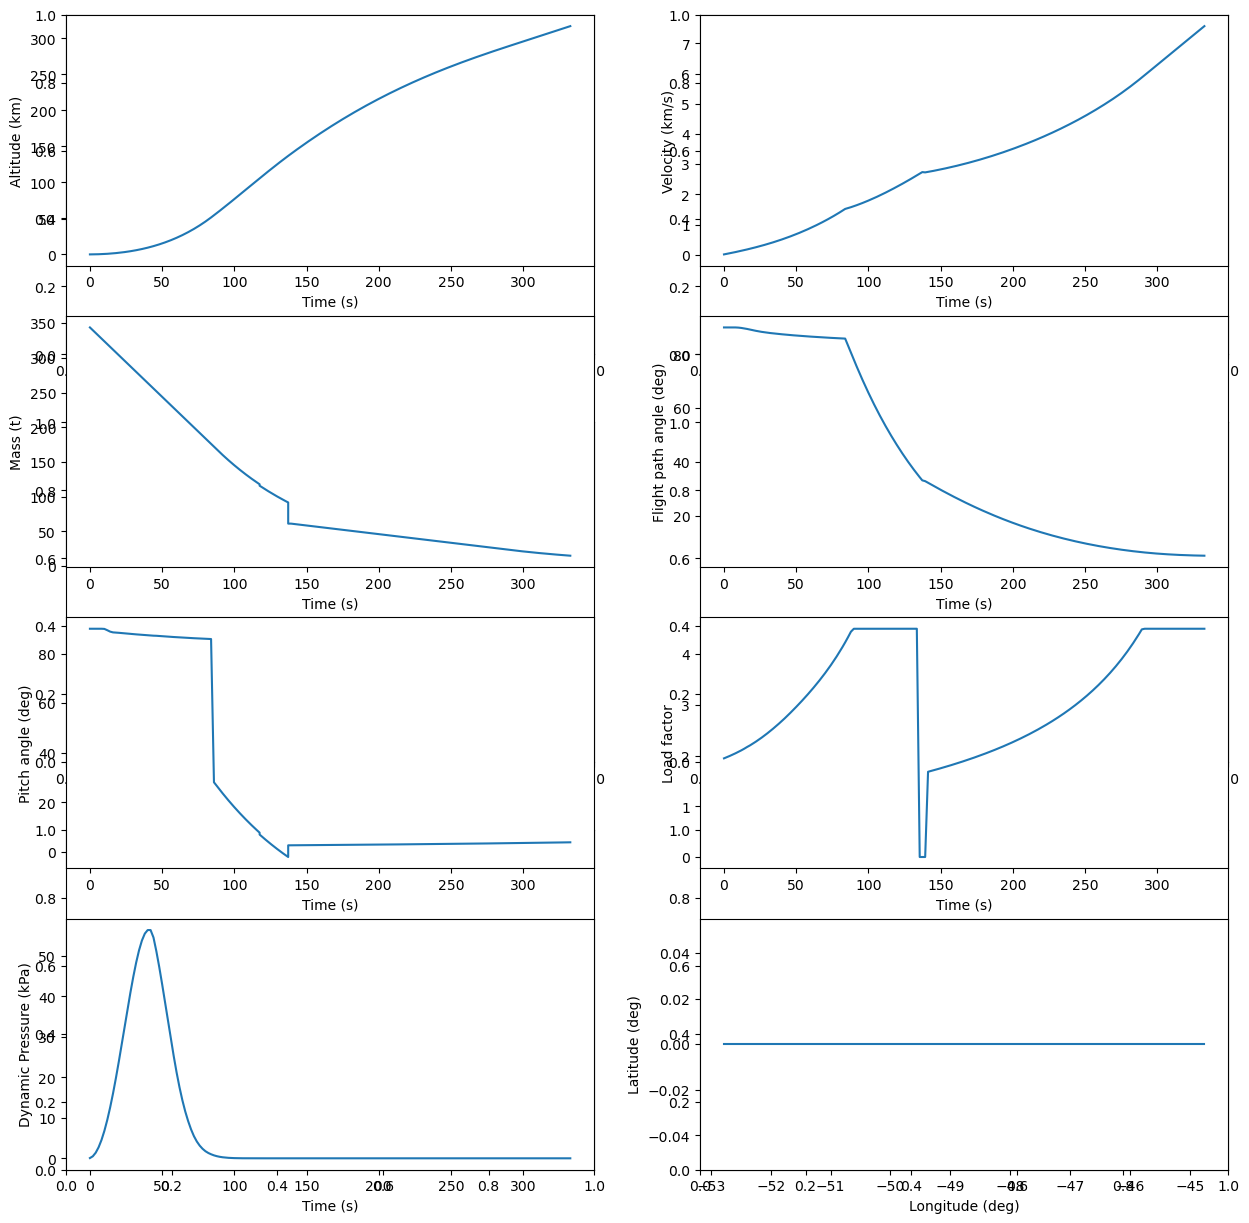

✓ Trajectory plots generated


In [10]:
"""
## Trajectory Visualization
"""

if converged:
    try:
        # Use FELIN visualization module
        result_vizualization.plots_output(prob)
        print("✓ Trajectory plots generated")
    except:
        # Fallback to basic plots
        nb_pts = int(prob['Nb_pt_ascent'][0])
        time = prob['T_ascent'][:nb_pts]
        altitude = prob['alt_ascent'][:nb_pts] / 1000
        velocity = prob['V_ascent'][:nb_pts]
        mass = prob['m_ascent'][:nb_pts] / 1000
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        
        axes[0,0].plot(time, altitude)
        axes[0,0].set_xlabel('Time (s)')
        axes[0,0].set_ylabel('Altitude (km)')
        axes[0,0].grid(True)
        axes[0,0].set_title('Altitude Profile')
        axes[0,0].axhline(y=MIN_ALTITUDE/1000, color='r', linestyle='--', alpha=0.5, label='Required')
        axes[0,0].legend()
        
        axes[0,1].plot(time, velocity)
        axes[0,1].set_xlabel('Time (s)')
        axes[0,1].set_ylabel('Velocity (m/s)')
        axes[0,1].grid(True)
        axes[0,1].axhline(y=MIN_DELTA_V, color='r', linestyle='--', alpha=0.5, label='Required ΔV')
        axes[0,1].set_title('Velocity Profile')
        axes[0,1].legend()
        
        axes[1,0].plot(time, mass)
        axes[1,0].set_xlabel('Time (s)')
        axes[1,0].set_ylabel('Mass (t)')
        axes[1,0].grid(True)
        axes[1,0].set_title('Mass Profile')
        
        axes[1,1].plot(time, prob['pdyn_ascent'][:nb_pts]/1000)
        axes[1,1].set_xlabel('Time (s)')
        axes[1,1].set_ylabel('Dynamic Pressure (kPa)')
        axes[1,1].grid(True)
        axes[1,1].set_title('Dynamic Pressure')
        
        plt.suptitle(f'Trajectory: {best_name} Solution')
        plt.tight_layout()
        plt.show()

In [11]:
"""
## Environmental Impact Breakdown
"""

if converged:
    print("=== ESA SINGLE SCORE BREAKDOWN ===")
    categories = ['GWP', 'ODEPL', 'PMAT', 'LUP', 'WDEPL']
    
    for cat in categories:
        try:
            raw = prob[f'ESA_{cat}'][0]
            normalized = prob[f'ESA_{cat}_normalized'][0]
            print(f"{cat:8} raw={raw:.2e}, normalized={normalized:.2e}")
        except:
            pass
    
    print(f"\nTotal ESA Score: {prob['ESA_single_score'][0]:.1f}")
    print(f"Total GWP: {prob['GWP_total'][0]/1e3:.1f} tCO2eq")
    
    # Material contribution to GWP
    print("\n=== MATERIAL CONTRIBUTIONS ===")
    print("High impact: CFRP (~30 kg CO2/kg)")
    print("Medium impact: Aluminum (~7-8 kg CO2/kg)")
    print("Low impact: Steel (~2.5 kg CO2/kg)")

=== ESA SINGLE SCORE BREAKDOWN ===
GWP      raw=2.18e+06, normalized=2.69e+02
ODEPL    raw=1.77e-01, normalized=3.29e+00
PMAT     raw=1.15e-01, normalized=1.94e+02
LUP      raw=8.07e+06, normalized=9.84e+00
WDEPL    raw=1.05e+06, normalized=9.14e+01

Total ESA Score: 82.8
Total GWP: 2177.1 tCO2eq

=== MATERIAL CONTRIBUTIONS ===
High impact: CFRP (~30 kg CO2/kg)
Medium impact: Aluminum (~7-8 kg CO2/kg)
Low impact: Steel (~2.5 kg CO2/kg)


In [ ]:
"""
## Export Results
"""

# Save comparison
comparison.to_csv('optimization_comparison.csv', index=False)
print("✓ Saved optimization_comparison.csv")

# Save best design with material details
x_best_denorm = lowerbnd + (upperbnd - lowerbnd) * x_best
best_design = pd.DataFrame({
    'Parameter': ['Prop_mass_1', 'Prop_mass_2', 'OF_1', 'OF_2', 
                  'S1_CFRP_%', 'S1_Al_%', 'S1_Steel_%',
                  'S2_CFRP_%', 'S2_Al_%', 'S2_Steel_%',
                  'ESA_Score', 'Delta_V', 'Altitude', 'GLOW'],
    'Value': [x_best_denorm[0], x_best_denorm[1], x_best_denorm[2], x_best_denorm[3],
              x_best_denorm[4]*100, x_best_denorm[5]*100, x_best_denorm[6]*100,
              x_best_denorm[7]*100, x_best_denorm[8]*100, x_best_denorm[9]*100,
              best_results['ESA_score'], best_results['delta_v'], 
              best_results['altitude']/1000, best_results['GLOW']/1000],
    'Unit': ['t', 't', '-', '-', '%', '%', '%', '%', '%', '%',
             '-', 'm/s', 'km', 't']
})
best_design.to_csv('best_design.csv', index=False)
print("✓ Saved best_design.csv")

print(f"\n{'='*60}")
print(f"OPTIMIZATION COMPLETE")
print(f"Best feasible ESA score: {best_results['ESA_score']:.1f}")
print(f"Material strategy: Optimize structural components only")
print(f"{'='*60}")

✓ Saved optimization_comparison.csv


NameError: name 'x_best_actual' is not defined